#### Node Embedding with Node2Vec in Stellargraph 

Requires Python 3.8

In [94]:
import os
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline
print("finished")

finished


In [125]:
# connect to the database, download data 
connection = pg.connect(host = 'postgis1', database = 'sdad', 
                        user = os.environ.get('db_user'), 
                        password = os.environ.get('db_pwd'))

edgelist = '''SELECT ctr1 AS source, ctr2 as target, repo_wts AS weight 
              FROM gh_sna.sna_intl_ctr_edgelist_dd_lchn_08
              WHERE ctr1 != ctr2 AND ctr1 NOT IN (SELECT * FROM gh.bots_table) AND ctr2 NOT IN (SELECT * FROM gh.bots_table);'''

nodelist = '''SELECT login, country_code_vis FROM gh_sna.sna_ctr_ctry_codes'''

edgelist = pd.read_sql_query(edgelist, con=connection)
node_attrs = pd.read_sql_query(nodelist, con=connection)
edgelist.head()

source      target  weight
0  ffainelli      juhosg   167.0
1       jow-        sbyx    57.0
2  ffainelli  teknoraver    56.0
3     juhosg  teknoraver    52.0
4        m8t     omaciel    51.0

In [126]:
node_attrs.head()

login country_code_vis
0      mcollina         multiple
1       geoffeg               us
2       carueda               us
3        benmur               us
4  diegopacheco               br

In [141]:
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr='weight') 

def average_degree(G):
    wtd_deg = list(G.degree(weight='weight'))
    avg_wtd_degree = round(sum([row[1] for row in wtd_deg]) / len([row[1] for row in wtd_deg]), 3)
    return avg_wtd_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(G)

print("Number of nodes: {}".format(num_edges))
print("Number of edges: {}".format(num_nodes))
print("Average degree: {}".format(avg_degree))

Number of nodes: 65921
Number of edges: 3856
Average degree: 49.221


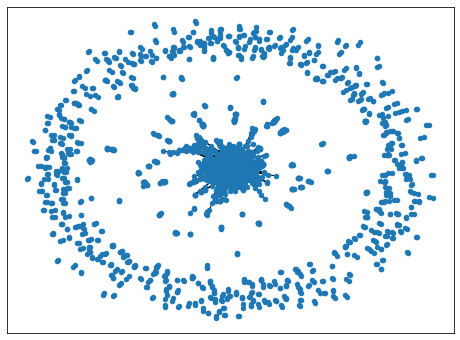

In [142]:
plt.figure(figsize=(8,6))
nx.draw_networkx(G, arrows=False, with_labels=False, node_size=20)

In [143]:
nodelist = list(G.nodes())
nodelist = pd.DataFrame(nodelist, columns=['login'])
nodelist.count()

login    3856
dtype: int64

In [145]:
nodelist = pd.merge(nodelist,node_attrs,on='login',how='left')
nodelist = nodelist.rename(columns={"country_code_vis": "country"})
nodelist

login country
0      ffainelli      us
1         juhosg      hu
2           jow-      de
3           sbyx      de
4     teknoraver      it
...          ...     ...
3851   ctenbrink      us
3852     hrovira      us
3853    saramsey      us
3854   cjbottaro      us
3855    swalterd      us

[3856 rows x 2 columns]

In [147]:
attrs = nodelist.country.to_dict()
nx.set_node_attributes(G, attrs, "country") # left off here
nx.get_node_attributes(G, 'country')

{}

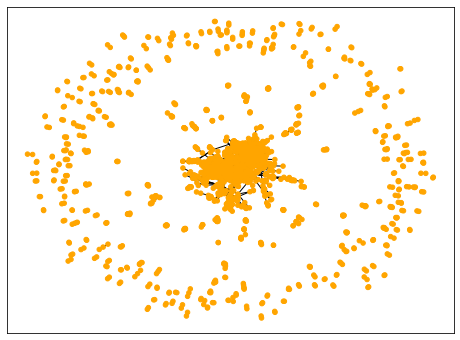

In [111]:


color_map = []
for node in G:
    if node == "Pesa":
        color_map.append('blue')
    else: 
        color_map.append('orange')      
plt.figure(figsize=(8,6))
nx.draw_networkx(G, node_color=color_map, arrows=False, with_labels=False, node_size=20)

#### Node Embedding 

First, we set the random walk global parameter and set a function for the jaccard_weights

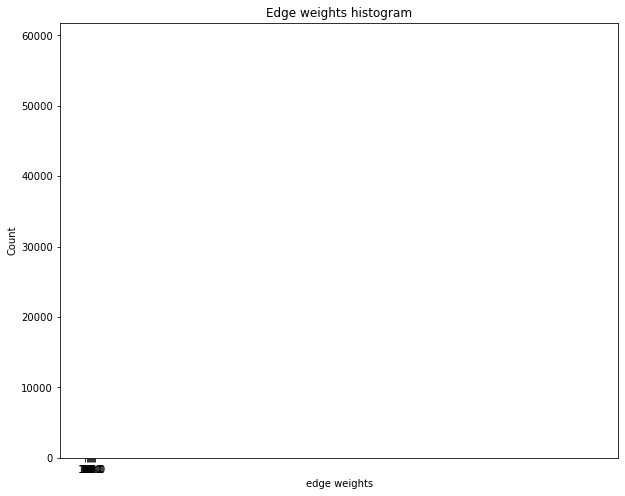

In [140]:
extract_weights = np.array(list(G.edges.data("weight")))
weights = extract_weights[:,2]

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [53]:
G = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(G)

In [55]:
walk_length = 100

weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unnormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unnormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 29820


In [58]:
weighted_model = Word2Vec(
    weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1, epochs=1
)

In [64]:
emb = weighted_model.wv['rmehta']
emb.shape

(128,)

In [71]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index_to_key  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = nodelist.loc[node_ids].astype("category")

In [72]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

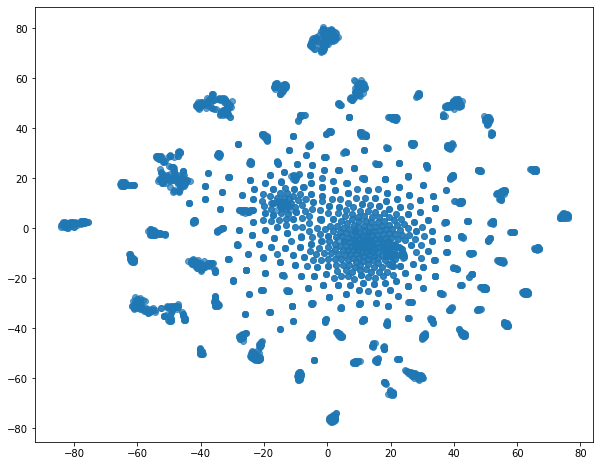

In [73]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    #c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

https://medium.com/stellargraph/can-graph-machine-learning-identify-hate-speech-in-online-social-networks-58e3b80c9f7e

In [93]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(
    largest_connected_component_only=True,
    edge_weights=jaccard_weights,
    str_node_ids=True,  # Word2Vec requires strings, not ints
)
subjects

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2485, dtype: object

In [83]:
nodes_list = np.array(list(G.nodes()))
node_name = nodes_list[4]
node_id = np.where(nodes_list)[0][0]
node_id

0

References 

https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html
https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
https://colab.research.google.com/drive/1b9rZIjD7MUEKwYbXZc3dchTBTpzdrvpd?usp=sharing#scrollTo=AUhES1VYo3tB